# Machine Learning analysis of NYC AirBnb Data

### Description:
This is an analysis used for a workshop with Destination Aarhus. This notebook covers data exploration, data pipelines and machine learning analysis. The tools used are Pandas for data handling, and scikit-learn and Keras for machine learning

# Code

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/nrs/Documents/Trifork/GOTOAcademy/DestAArhus/NYC_AirBnb')
from utils import *
from utilsEve import *

We set the random seeds for reproducability

In [2]:
np.random.seed(RANDOM_STATE)

### Import data
import data via CSV file into a pandas dataframe

In [3]:
df = importDataCSV('../NYC_AirBnb/AB_NYC_2019.csv')
dropColumns(df, ['host_name', 'name', 'id', 'host_id'])

## (1) Data overview

In [4]:
df[['price', 'minimum_nights']].describe()

,price,minimum_nights
count,48895.000000,48895.000000
mean,152.720687,7.029962
std,240.154170,20.510550
min,0.000000,1.000000
25%,69.000000,1.000000
50%,106.000000,3.000000
75%,175.000000,5.000000
max,10000.000000,1250.000000


### Map objects to categories

In [5]:
df[df.select_dtypes('object').columns] = df.select_dtypes('object').astype('category')

### Create a training and test set to avoid data snooping

In [6]:
df, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)

### Missing values

In [7]:
mapMissingValues(df)

,Total,Percent
reviews_per_month,6990,0.204231
last_review,6990,0.204231
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000
longitude,0,0.000000
latitude,0,0.000000


#### Provide custom operations to deal with missing values - add logic in logic comment cell with a reference

In [8]:
def handleNaN(df, df_test):
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0) #1
    df_test['reviews_per_month'] = df_test['reviews_per_month'].fillna(0) 

    df['last_review'] = pd.to_datetime(df['last_review'],infer_datetime_format=True) #2
    df_test['last_review'] = pd.to_datetime(df_test['last_review'],infer_datetime_format=True)

    earliest = min(df['last_review'].dropna()) #3

    df['last_review'] = df['last_review'].fillna(earliest) #4
    df_test['last_review'] = df_test['last_review'].fillna(earliest)

    df['last_review'] = df['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal()) #5
    df_test['last_review'] = df_test['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())
    
    return df, df_test

df, df_test = handleNaN(df, df_test)

Logic comment cell
1. If no reviews are available then fill NaN with zeros 
2. Change the date format to a readable datetime format
3. Find the earliest date in the training set, which we will use for the missing values
4. Fill the missing values with the earliest date
5. Change the datetime format into a continous format thats readable for the ML models

#### Sanity check

In [9]:
mapMissingValues(df)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


In [10]:
mapMissingValues(df_test)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


## Naive Machine Learning 

In [16]:
dfy = df.copy()
dfy[dfy.select_dtypes(include=['category']).columns.tolist()] = dfy[dfy.select_dtypes(include=['category']).columns.tolist()].apply(lambda x: x.cat.codes)
features_od_naive = [i for i in dfy.columns.tolist() if not 'price' in i]

In [17]:
n_folds = 5
for Model in [XGBRegressor]:
    if Model == XGBRegressor: 
        cv_res = rmse_cv(XGBRegressor(objective='reg:linear'), n_folds, dfy[features_od_naive], dfy['price'])
    else: 
        cv_res = rmse_cv(Model(), n_folds, dfy[features_od_naive], dfy['price'])
    print('{}: {:.2f} +/- {:2f}'.format(Model.__name__, np.sqrt(-cv_res.mean()), np.sqrt(cv_res.std())))

XGBRegressor: 217.88 +/- 170.162292


## (3) Exploration

### Visual exploration

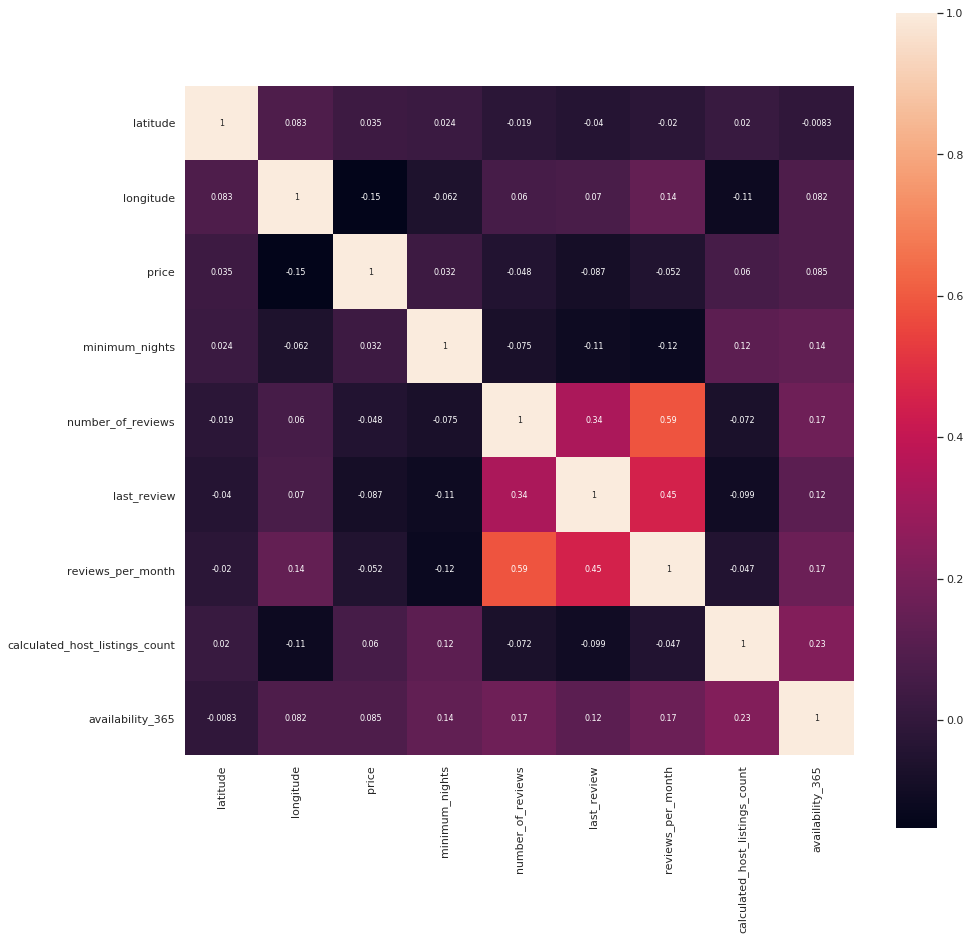

In [28]:
plotContinuousRelations(df, loud=False)

### Logarithmic function

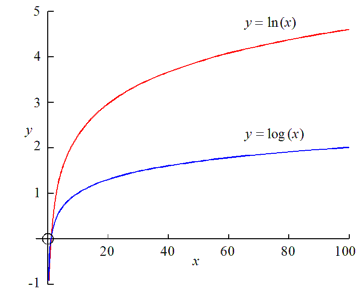

In [55]:
from IPython.display import Image
Image('functions60.gif')

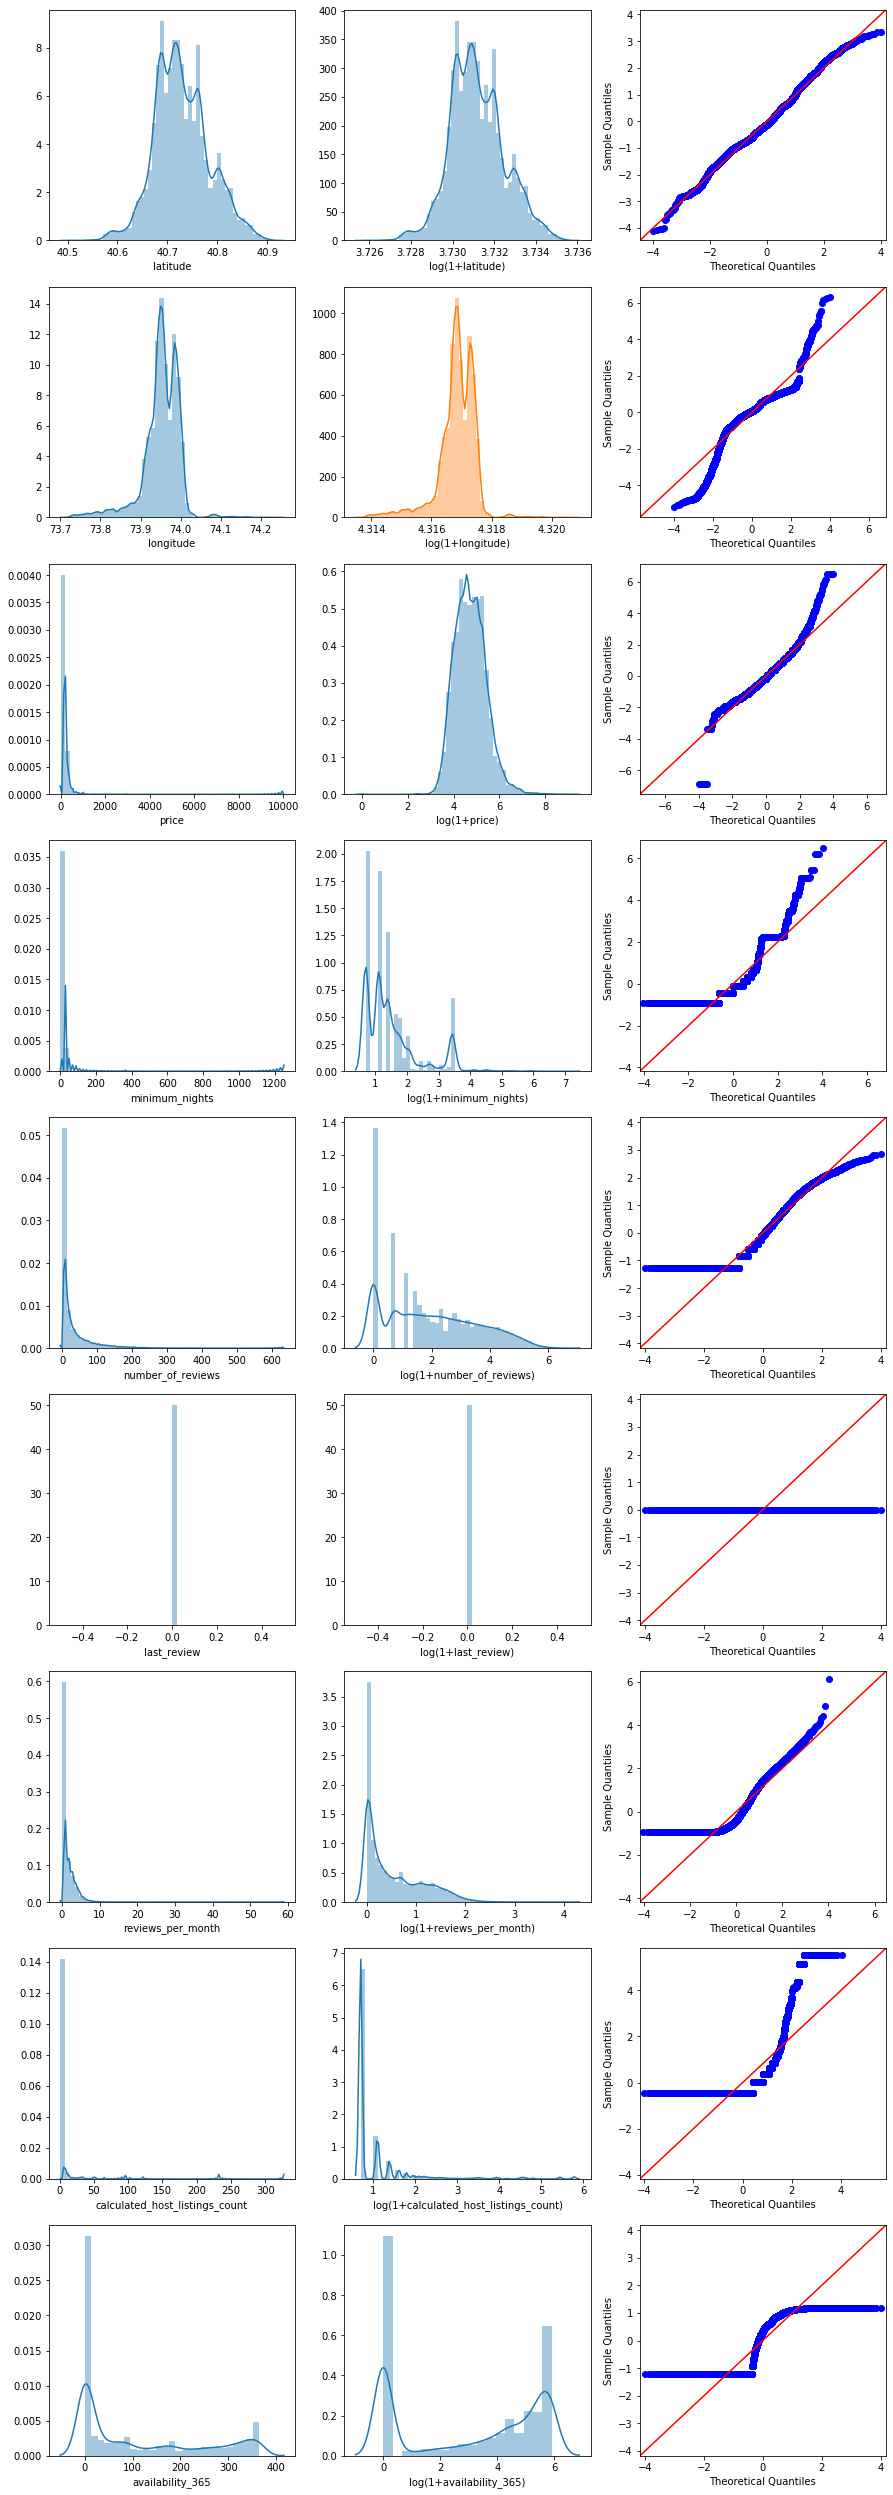

In [54]:
logTransformPlot(df)

## (4) Data Transformation 

In [11]:
df_rd, df_test_rd = transformData(df, df_test)

Logic comment cell
1. Dropping categorical column as it provides noise
2. Creating dummy features for categorical columns
3. log transforming price to create normal distribution and include positive outliers - Dont drop price as column
4. -9 Log transforming continous variables
7. dropping all level columns that have been log transformed

## (5)  Model selection (price as y) 
Test different models when you want to predict the price without a log transformation - We are working with the dataframe df_rd

In [18]:
df_rd['intercept'] = 1
df_test_rd['intercept'] = 1
features_ms = [i for i in df_rd.columns.tolist() if not 'log_price' in i and not 'price' in i] #and not 'dm' in i]
if 'intercept' not in features_ms:
    features_ms.append('intercept')

In [19]:
n_folds = 5
for Model in [XGBRegressor()]:
    if Model == XGBRegressor: 
        cv_res = rmse_cv(XGBRegressor(objective='reg:linear'), n_folds, df_rd[features_ms], df_rd['price'])
    else: 
        cv_res = rmse_cv(Model, n_folds, df_rd[features_ms], df_rd['price'])
        
    print('{}: {:.2f} +/- {:2f}'.format(Model.__class__.__name__, np.sqrt(-cv_res.mean()), np.sqrt(cv_res.std())))

XGBRegressor: 218.36 +/- 169.571014


## (6)  Model selection (log_price as y) 

In [20]:
n_folds = 5
for Model in [XGBRegressor()]:
    if Model == XGBRegressor: 
        cv_res = rmse_cv(XGBRegressor(objective='reg:linear'), n_folds, df_rd[features_ms], df_rd['log_price'])
    else: 
        cv_res = rmse_cv(Model, n_folds, df_rd[features_ms], df_rd['log_price'])
        
    print('{}: {:.2f} +/- {:2f}'.format(Model.__class__.__name__, np.expm1(np.sqrt(-cv_res.mean())), np.expm1(np.sqrt(cv_res.std()))))

XGBRegressor: 0.57 +/- 0.084620


In [21]:
for model in [XGBRegressor()]:
    model.fit(df_rd[features_ms], df_rd['log_price'])
    y_train_pred = model.predict(df_rd[features_ms])
    y_test_pred = model.predict(df_test_rd[features_ms])
    print('\n-------------------------')
    
    print('\n{}\n\nTRAIN\nRMSE: {:.2f} - R² {:.2f}'.format(model.__class__.__name__, 
                                                           np.expm1(np.sqrt(mean_squared_error(df_rd['log_price'], 
                                                                                               y_train_pred))), 
                                                           r2_score(df_rd['log_price'], y_train_pred)))
    
    print('\nTEST\nRMSE: {:.2f} - R² {:.2f}'.format(np.expm1(np.sqrt(mean_squared_error(df_test_rd['log_price'], 
                                                                                        y_test_pred))), 
                                                    r2_score(df_test_rd['log_price'], 
                                                             y_test_pred)))
    


-------------------------

XGBRegressor

TRAIN
RMSE: 0.56 - R² 0.59

TEST
RMSE: 0.58 - R² 0.58


## (7) Hyperparameter optimization 

In [48]:
features_xgb = [i for i in df_rd.columns.tolist() if not 'log_price' in i and not 'price' in i]

### Baseline model

In [39]:
xgb_base = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = RANDOM_STATE)
cv_res = cross_val_score(xgb_base, df_rd[features_xgb], df_rd['log_price'], scoring='neg_mean_squared_error', cv=kf)
xgb_base.fit(df_rd[features_xgb], df_rd['log_price'])
y_train_xgb_base = xgb_base.predict(df_rd[features_xgb])
y_test_xgb_base = xgb_base.predict(df_test_rd[features_xgb])

xgb_base_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': np.sqrt(-cv_res.mean()), 
            'CV std': np.sqrt(cv_res.std()),
            'Training RMSE': [np.expm1(np.sqrt(mean_squared_error(y_train_xgb_base, df_rd['log_price'])))],
            'Training R²' : [r2_score(df_rd['log_price'], y_train_xgb_base)],
            'Test RMSE': [np.expm1(np.sqrt(mean_squared_error(df_test_rd['log_price'], y_test_xgb_base)))], 
            'Test R²' : [r2_score(df_test_rd['log_price'], y_test_xgb_base)]})

xgb_base_results

,CV error,CV std,Test RMSE,Test R²,Training RMSE,Training R²,algorithm
0,0.439672,0.081378,0.569087,0.594433,0.52006,0.631798,XGBRegressor[baseline]


### Exhaustive Gridsearch

In [40]:
d = {
            'Learning Rate' : [],
            'Max depth' : [],
            'Min child weight' : [],
            'CV RMSE': [], 
            'CV std': [],
            'Training RMSE': [],
            'Training R²' : [],
            'Test RMSE': [], 
            'Test R²' : []}

params = {'max_depth': list(range(3,4)), 'min_child_weight': list(range(2,3)), 'lr': [0.01, 0.05, 0.1]}
for md in params['max_depth']:
    for mcw in params['min_child_weight']:
        for lr in params['lr']:

            xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5, max_depth=md, min_child_weight=mcw )            
            cv_res = cross_val_score(xgb_model, df_rd[features_xgb], df_rd['log_price'], scoring='neg_mean_squared_error', cv=kf)
            xgb_model.fit(df_rd[features_xgb], df_rd['log_price'])
            y_train_xgb_model = xgb_model.predict(df_rd[features_xgb])
            y_test_xgb_model = xgb_model.predict(df_test_rd[features_xgb])
            
            d['Learning Rate'].append(lr)
            d['Max depth'].append(md)
            d['Min child weight'].append(mcw)
            d['CV RMSE'].append(np.sqrt(-cv_res.mean()))
            d['CV std'].append(np.sqrt(cv_res.std()))
            d['Training RMSE'].append(np.expm1(np.sqrt(mean_squared_error(y_train_xgb_model, df_rd['log_price']))))
            d['Training R²'].append(r2_score(df_rd['log_price'], y_train_xgb_model))
            d['Test RMSE'].append(np.expm1(np.sqrt(mean_squared_error(df_test_rd['log_price'], y_test_xgb_model))))
            d['Test R²'].append(r2_score(df_test_rd['log_price'], y_test_xgb_model))

xgb_tuning = pd.DataFrame(d)
xgb_tuning

,CV RMSE,CV std,Learning Rate,Max depth,Min child weight,Test RMSE,Test R²,Training RMSE,Training R²
0,0.448156,0.081274,0.01,3,2,0.584877,0.576203,0.555614,0.590016
1,0.439745,0.082928,0.05,3,2,0.569295,0.594193,0.520840,0.630895
2,0.438167,0.080167,0.10,3,2,0.565059,0.599047,0.497222,0.657938


## (8) Deep learning - Coding assignment
We are gonna use a deep and wide neural network. This is because neural networks cant handle sparse data very well. A deep and wide model is a combination on a linear model and a neural network

Tensorflow estimators cant handle feature names with whitespace. So we remove it

In [22]:
features_dl = [i.replace(' ', '') for i in df_rd.columns.tolist()]
df_rd.columns, df_test_rd.columns = features_dl, features_dl

We extract all the features for the model

In [23]:
features_dl = [i for i in df_rd.columns.tolist() if not 'log_price' in i and not 'price' in i]

The wide features for the linear model

In [24]:
features_wide = [i for i in features_dl if not 'dm' in i and not 'intercept' in i]

The deep features for the neural network

In [25]:
features_deep = [i for i in features_dl if 'dm' in i]

### (8.1) Coding assignment

Tensoflow requires a specific format for the input features. We define them using the numeric_column method.
You neep to append the correct features for the appropriate lists

In [26]:
tf_variables_wide = []

for index in features_wide:
    tf_variables_wide.append(tf.feature_column.numeric_column(index)) 
    
tf_variables_deep = []
    
for index in features_deep:
    tf_variables_deep.append(tf.feature_column.numeric_column(index)) 

### (8.2) Coding assignment
Insert at propper batch size and number of epochs. No correct solution 

In [27]:
BATCH_SIZE = 32
EPOCHS = 5
STEPS = math.ceil(EPOCHS * df_rd.shape[0] / BATCH_SIZE)

We define the input functions for our training and test set. 

In [28]:
train_input_func = tf.estimator.inputs.pandas_input_fn(x=df_rd[features_dl], 
                                                y= df_rd['log_price'],
                                                batch_size=BATCH_SIZE, 
                                                num_epochs=None, 
                                                shuffle=True)

test_input_func = tf.estimator.inputs.pandas_input_fn(x=df_test_rd[features_dl], 
                                                y= df_test_rd['log_price'],                                                  
                                                 batch_size=1, 
                                                 num_epochs=1, 
                                                 shuffle=False)

### (8.3) Coding assignment
The optimizer is the first hyperparameter we can tune. It includes another important hyperparameter which is the learning rate


In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate = 0.01)

Now we define the model. It includes dnn_hidden_units which is the number of nodes in each hidden layer

In [30]:
timestamp = calendar.timegm(time.gmtime())
os.mkdir('./{}'.format(timestamp))

wdnn = tf.estimator.DNNLinearCombinedRegressor(
    model_dir='./{}'.format(timestamp),
    linear_feature_columns=tf_variables_wide,
    dnn_feature_columns=tf_variables_deep,
    dnn_optimizer=optimizer,
    dnn_hidden_units=[10])

NameError: name 'calendar' is not defined

We train for 20000 steps

In [51]:
wdnn.train(input_fn=train_input_func,steps=STEPS)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into ./1/model.ckpt.
INFO:tensorflow:loss = 756.49225, step 

We check the high level model performance of the training and test sets. We need to redefine the training input function for evaluation

In [52]:
train_input_func_eval = tf.estimator.inputs.pandas_input_fn(x=df_rd[features_dl], 
                                                y= df_rd['log_price'],
                                                batch_size=1, 
                                                num_epochs=1, 
                                                shuffle=False)

result_train = wdnn.evaluate(input_fn=train_input_func_eval)
result_train

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-24T08:05:38Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./1/model.ckpt-5348
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-24-08:09:13
INFO:tensorflow:Saving dict for global step 5348: average_loss = 0.24507682, global_step = 5348, label/mean = 4.7347035, loss = 0.24507682, prediction/mean = 4.718938
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5348: ./1/model.ckpt-5348


{'average_loss': 0.24507682,
 'global_step': 5348,
 'label/mean': 4.7347035,
 'loss': 0.24507682,
 'prediction/mean': 4.718938}

In [53]:
result_test = wdnn.evaluate(input_fn=test_input_func)
result_test

INFO:tensorflow:Could not find trained model in model_dir: ./1, running initialization to evaluate.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-24T08:09:14Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-24-08:10:37
INFO:tensorflow:Saving dict for global step 0: average_loss = 30.337816, global_step = 0, label/mean = 4.74143, loss = 30.337816, prediction/mean = -0.69714284


{'average_loss': 30.337816,
 'global_step': 0,
 'label/mean': 4.74143,
 'loss': 30.337816,
 'prediction/mean': -0.69714284}

We check the medium level model performance

In [54]:
train_predictions=[]
test_predictions=[]

for train_pred in wdnn.predict(input_fn=train_input_func_eval):
    train_predictions.append(np.array(train_pred['predictions']).astype(float))
    
for test_pred in wdnn.predict(input_fn=test_input_func):
    test_predictions.append(np.array(test_pred['predictions']).astype(float))

print('Train RMSE: {:.2f} - R²: {:.2f}'.format(np.expm1(np.sqrt(mean_squared_error(df_rd['log_price'], train_predictions))),
                                      r2_score(df_rd['log_price'], train_predictions)))

print('Test RMSE: {:.2f} - R²: {:.2f}'.format(np.expm1(np.sqrt(mean_squared_error(df_test_rd['log_price'], test_predictions))),
                                      r2_score(df_test_rd['log_price'], test_predictions)))    


INFO:tensorflow:Could not find trained model in model_dir: ./1, running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Could not find trained model in model_dir: ./1, running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Train RMSE: 134.13 - R²: -49.54
Test RMSE: 100.89 - R²: -41.73


## Open Tensorboard in the launcher from your directory
We use tensorboard to monitor the training process. This is the low level monitoring.